In [28]:
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

# Import Data from CSV

In [243]:
# data = pd.read_csv('20210201_parsed_run3_data.csv',index_col=0)
data = pd.read_csv('./debug_data/dyn_model_data.csv', names=['x', 'y', 'psi', 'vx', 'vy', 'r', 'theta', 'steer', 'vtheta', 'D', 'delta'])
# data['time'] -= 275.036 # let's start at 0 this shouldnt make a difference
# data['x'] -= data['x'][0]
# data['x'] *= -1
# data['y'] -= data['y'][0]
# data['psi'] += math.pi / 6
# data['delta'] = (data['steer'].shift(-1) - data['steer']) / (data['time'].shift(-1) - data['time']) 

In [244]:
data.head()

,x,y,psi,vx,vy,r,theta,steer,vtheta,D,delta
0,0.000,0.000000e+00,0.000000e+00,5.0,0.000000,0.000000,0,0.00000,0,0.0000,0.15
1,0.005,0.000000e+00,0.000000e+00,5.0,0.000000,0.000000,0,0.00015,0,0.0004,0.15
2,0.010,0.000000e+00,0.000000e+00,5.0,-0.000015,-0.000020,0,0.00030,0,0.0008,0.15
3,0.015,-1.505900e-08,-1.964700e-08,5.0,-0.000044,-0.000057,0,0.00045,0,0.0012,0.15
4,0.020,-5.930000e-08,-7.705900e-08,5.0,-0.000086,-0.000112,0,0.00060,0,0.0016,0.15


# Bicycle Model

In [245]:
def tire_force(alpha, Fz, p):
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p
    return -alpha * cornering_stiff * (Fz / sample_fz)

def normal_force(vx, p):
    g = 9.8
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    # traction due to aero
    F_lift = 0.5*rho*cla*(vx**2)
    FzF = -(lr * (m * g + F_lift)) / l;
    FzR = -(lf * (m * g + F_lift)) / l;
    
    return FzF, FzR

def dynamic_model(t, x, p):
    x, y, psi, vx, vy, r = x  # position
    D, steer = data['D'][math.floor(t / 0.005)], data['steer'][math.floor(t / 0.005)] # we will just take these based off the t input
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
    
    # estimate normal
    FzF, FzR = normal_force(vx, p)
    
    # compute slip angles
    alpha_f = math.atan((vy + r * lf) / vx) + steer
    alpha_r = math.atan((vy - r * lr) / vx)
    
    # compute tire forces
    F_yf = tire_force(alpha_f, FzF, p)
    F_yr = tire_force(alpha_r, FzR, p)
    
    # torque to force
    F_net = m * D
    
    # torque vectoring
    F_xf = lf / l * F_net
    F_xr = lr / l * F_net
    
    # accel
    ax = 1/m * (F_xr + F_xf * math.cos(steer) + F_yf * math.sin(steer)) + r * vy
    ay = 1/m * (F_yr - F_xf * math.sin(steer) + F_yf * math.cos(steer)) - r * vx
    a_yaw = 1/Iz * (-lf * F_xf * math.sin(steer) + lf * F_yf * math.cos(steer) - lr * F_yr)
    
    # bicycle model
    new_vx = vx * math.cos(psi) - vy * math.sin(psi)  # sin/cos(x), x should be radians.. not sure if our data is in deg/rad
    new_vy = vx * math.sin(psi) + vy * math.cos(psi)
    
    return [new_vx, new_vy, r, ax, ay, a_yaw]
    
    
def kinematic_model(t, x, p):
    x, y, psi, vx, vy, r = x  # position
    D, steer = data['D'][math.floor(t*1e3)], data['steer'][math.floor(t*1e3)]
#     vtheta, D, delta = kin['vtheta'][int(t*1e3)], kin['D'][math.floor(t*1e3)], kin['delta_calc'][math.floor(t*1e3)] # TODO
#     vtheta, D, delta = u # inputs
    m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla = p # params of the car
#     vtheta
    beta = math.atan((math.tan(-steer) * lr)/l)
    ax = D * math.cos(beta)
    ay = D * math.sin(beta)
    
    dx = vx * math.cos(psi + beta)
    dy = vx * math.sin(psi + beta)
    dpsi = math.tan(-steer) * (vx * math.cos(beta)) / l # Note: R.Rajamani uses opposite steering coordinates
    
    dvx = ax
    dvy = ay
    dr = vx / lr * math.sin(beta)
    
    return np.array([dx, dy, dpsi, ax, ay, dr])


In [246]:
# # defining our variables for our simulated data
# y0 = [data[c][0] for c in data.columns[1:7]]
# timespan = 5
# num_pts = 25*timespan + 1
# tspan = np.linspace(0, timespan, num_pts)
# p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (357, 2.971, 2.01, 0.960, 550.0, 125116, 4000, 1.225, -1.034)
# # p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (350.0, 2.6, 1.2, 1.4, 550.0, 1000.0, 3430.0, 1.2, -0.5)

In [247]:
y0 = np.array([0, 0, 0, 5, 0, 0])
timespan = 5
num_pts = 1000*timespan + 1
tspan = np.linspace(0, timespan, num_pts)
p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (0, 2.971, 0, 0.960, 0, 0, 0, 0, 0)

In [248]:
# dynamic model
# sol = solve_ivp(dynamic_model, (0, timespan), y0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)
# sol

In [249]:
sol = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 86
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.000e+00, 1.000e-03, 2.000e-03, ..., 4.998e+00, 4.999e+00,
       5.000e+00])
 t_events: None
        y: array([[ 0.00000000e+00,  5.00000007e-03,  1.00000005e-02, ...,
         2.72708504e+01,  2.72761075e+01,  2.72813642e+01],
       [ 0.00000000e+00, -1.15322742e-07, -4.62612377e-07, ...,
        -1.86507306e+00, -1.86563644e+00, -1.86619918e+00],
       [ 0.00000000e+00, -1.19894602e-07, -4.80122445e-07, ...,
        -1.19877890e-01, -1.19805828e-01, -1.19733547e-01],
       [ 5.00000000e+00,  5.00000019e+00,  5.00000076e+00, ...,
         5.28734351e+00,  5.28695980e+00,  5.28657621e+00],
       [ 0.00000000e+00, -5.76459065e-13, -2.75682400e-11, ...,
         5.70675977e-03,  5.70173868e-03,  5.69670346e-03],
       [ 0.00000000e+00, -1.19894602e-07, -4.80122445e-07, ...,
        -1.19877890e-01, 

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


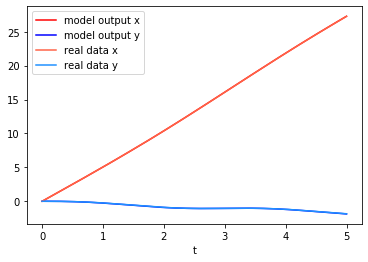

In [250]:
# let's plot this solution to see what it looks like against the real
plt.plot(tspan, sol.y[0,:], 'r', label='model output x')
plt.plot(tspan, sol.y[1,:], 'b', label='model output y')
plt.plot(tspan, data['x'][:num_pts], 'tomato', label='real data x')
plt.plot(tspan, data['y'][:num_pts], 'dodgerblue', label='real data y')
# plt.plot(t, sol[:, 2], 'g', label='model output psi')
# plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

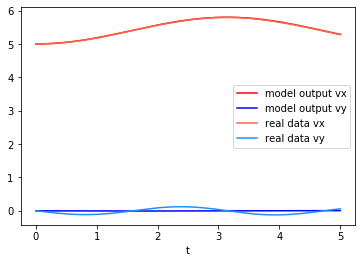

In [253]:
# let's plot this solution to see what it looks like against the real
plt.plot(tspan, sol.y[3,:], 'r', label='model output vx')
plt.plot(tspan, sol.y[4,:], 'b', label='model output vy')
plt.plot(tspan, data['vx'][:num_pts], 'tomato', label='real data vx')
plt.plot(tspan, data['vy'][:num_pts], 'dodgerblue', label='real data vy')
# plt.plot(t, sol[:, 2], 'g', label='model output psi')
# plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


plt.legend(loc='best')
plt.xlabel('t')
plt.show()

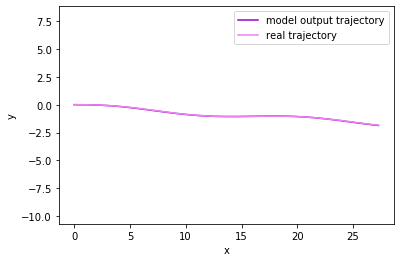

In [254]:
# let's plot just the xy trajectory
plt.plot(sol.y[0, :], sol.y[1, :], 'darkviolet', label='model output trajectory')
plt.plot(data['x'][:num_pts], data['y'][:num_pts], 'violet', label='real trajectory')
# plt.plot(data['x'], data['y'], 'violet', label='real trajectory')
plt.axis('equal')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Parameter Estimation

In [271]:
def plot_params(p):
    t = tspan
    pred_solver = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p,), rtol=1e-5, atol=1e-5)
    pred = pred_solver.y
    new_sol = np.swapaxes(pred, 0, 1)
#     new_sol = odeint(bicycle_model, u0, t, args=(p,))
    
    # let's plot this solution to see what it looks like against the real
    plt.plot(t, new_sol[:, 0], 'r', label='model output x')
    plt.plot(t, data['x'][:num_pts], 'tomato', label='real x')
    plt.plot(t, new_sol[:, 1], 'b', label='model output y')
    plt.plot(t, data['y'][:num_pts], 'dodgerblue', label='real y')
#     plt.plot(t, new_sol[:, 2], 'g', label='model output psi')
#     plt.plot(t, data['psi'][:num_pts], 'springgreen', label='real psi')


    plt.legend(loc='best')
    plt.xlabel('t')
    plt.show()
    
    # let's plot the velocity too
    plt.plot(t, new_sol[:, 3], 'r', label='model output vx')
    plt.plot(t, data['vx'][:num_pts], 'tomato', label='real vx')
    plt.plot(t, new_sol[:, 4], 'b', label='model output vy')
    plt.plot(t, data['vy'][:num_pts], 'dodgerblue', label='real vy')
#     plt.plot(t, new_sol[:, 5], 'g', label='model output r')
#     plt.plot(t, data['r'][:num_pts], 'springgreen', label='real r')


    plt.legend(loc='best')
    plt.xlabel('t')
    plt.show()
    
    
    # let's plot just the xy trajectory
    plt.plot(new_sol[:, 0], new_sol[:, 1], 'darkviolet', label='model output trajectory')
    plt.plot(data['x'][:num_pts], data['y'][:num_pts], 'violet', label='real trajectory')
    plt.legend(loc='best')
    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [272]:
pred_solver = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p0,), rtol=1e-5, atol=1e-5)

In [276]:
# TODO: probably want to normalize this error
# l2 = np.square(sol - pred).sum()

sol = data[:timespan*1000+1][data.columns[0:6]].to_numpy()

iters = 0
def callback(p):
    global iters
    iters += 1
    
    if iters % 100 == 0:
        print(cost(p))

def cost(p):
    pred_solver = solve_ivp(kinematic_model, (0, timespan), y0, t_eval=tspan, args=(p,), rtol=1e-5, atol=1e-5)
    pred = pred_solver.y
    pred = np.swapaxes(pred, 0, 1)
#     print(sol[:,[0, 1, 3, 4]])
    return np.square(sol[:,[0, 1, 3, 4]] - pred[:,[0, 1, 3, 4]]).sum()

In [277]:
p0 = (m, l, lf, lr, Iz, cornering_stiff, sample_fz, rho, cla) = (0, 100, 0, 50, 0, 0, 0, 0, 0)

In [278]:
minimization = minimize(cost, p0, method='Nelder-Mead', tol=1e-7, options={'maxiter':1e7}, callback=callback)

1653.0202758047
35.307401638722425
35.22841313232381
35.22764147162036
35.227530327743466
35.22751272876121


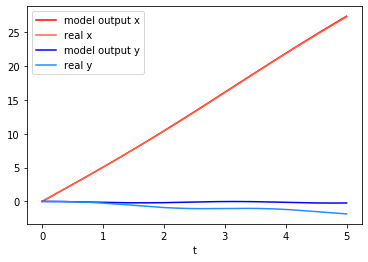

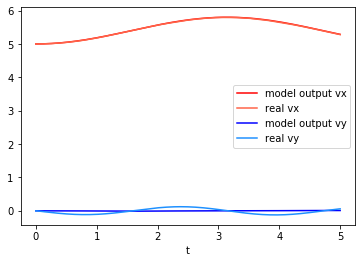

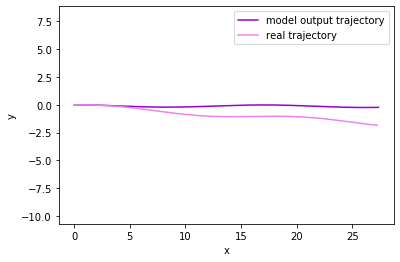

In [279]:
plot_params(p0)

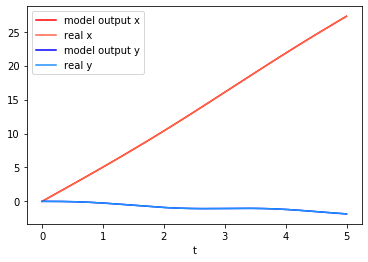

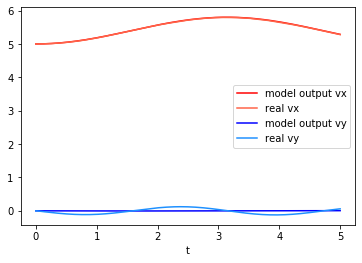

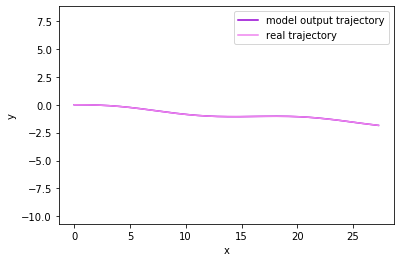

In [280]:
plot_params(tuple(minimization.x))

In [281]:
print(minimization.x[1], minimization.x[3])

2.949955036224214 0.7489152000526462
